In [27]:
import os 
import re

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pandas as pd
from scipy.stats import norm, multivariate_normal
from theano import tensor as tt

# import rpy2.robjects as robjects
# %load_ext rpy2.ipython

# from pymc import *

print(f"Running on PyMC v{pm.__version__}")

ModuleNotFoundError: No module named 'theano'

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

Find and create file paths to read in

In [3]:
dat = pd.read_csv("surprise_correct_data.csv")
dat.head()

,subj_name,rt,zrt,CT,SC,BL,BF,subj_id,movie_id,lrt
0,1,728,0.037347,Congruent,Surprise,1,1,1,9_effect.mov,-3.287507
1,1,1178,1.770961,Congruent,Surprise,1,1,1,3_effect.mov,0.571522
2,1,1062,1.324074,Congruent,Surprise,1,1,1,8_effect.mov,0.280713
3,1,795,0.295463,Congruent,Surprise,1,1,1,7_effect.mov,-1.219213
4,1,444,-1.056756,Congruent,No Surprise,1,1,1,2_noeffect.mov,NaN


In [5]:
dat["RT"] = dat["rt"] / 1000
dat.head()

,subj_name,rt,zrt,CT,SC,BL,BF,subj_id,movie_id,lrt,RT
0,1,728,0.037347,Congruent,Surprise,1,1,1,9_effect.mov,-3.287507,0.728
1,1,1178,1.770961,Congruent,Surprise,1,1,1,3_effect.mov,0.571522,1.178
2,1,1062,1.324074,Congruent,Surprise,1,1,1,8_effect.mov,0.280713,1.062
3,1,795,0.295463,Congruent,Surprise,1,1,1,7_effect.mov,-1.219213,0.795
4,1,444,-1.056756,Congruent,No Surprise,1,1,1,2_noeffect.mov,NaN,0.444


In [8]:
unique_ids = dat['subj_id'].unique()
unique_ids

array([  1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  33,  34,  35,  36,  37,  38,  40,  41,  42,  43,
        44,  46,  47,  48,  49,  50,  51,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  77,  78,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  91,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115,
       116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132])

In [18]:
sampled_ids = pd.Series(unique_ids).sample(n=min(10, len(unique_ids)), random_state=1)
sampled_ids

95     106
54      61
59      66
117    130
77      86
46      53
31      35
81      91
48      55
98     109
dtype: int64

In [19]:
subset_df = dat[dat["subj_id"].isin(sampled_ids)]
subset_df.shape

(2947, 11)

In [20]:
subset_df.head()

,subj_name,rt,zrt,CT,SC,BL,BF,subj_id,movie_id,lrt,RT
9257,33,2127,5.426961,Incongruent,Surprise,1,1,35,2_effect.mov,1.691379,2.127
9258,33,1742,3.943758,Congruent,Surprise,1,1,35,10_effect.mov,1.372134,1.742
9259,33,1479,2.930556,Congruent,No Surprise,1,1,35,2_noeffect.mov,1.075192,1.479
9260,33,1632,3.519985,Incongruent,Surprise,1,1,35,4_effect.mov,1.258457,1.632
9261,33,1209,1.890388,Incongruent,No Surprise,1,1,35,2_noeffect.mov,0.636782,1.209


In [22]:
# Create a mask that selects rows where 'SC' is "Surprise" and 'BL' is 1
mask = (subset_df["SC"] == "Surprise") & (subset_df["BL"] == 1)
flanker = subset_df[mask]
flanker.shape

(419, 11)

Read in and concatenate files to DataFrame

Create dataset for analysis

In [4]:
flanker = flanker.drop("unused", axis=1)
# binary variable for congruency
flanker['congruent'] = [0 if cond == 0 else 1 for cond in flanker.cond]
# filter out unnecessary rows
mask = "correct == 1 & rt > 0.2 & rt < 2 & cond != 1"
flanker = flanker.query(mask)

Pymc3 Model

In [5]:
flanker.head()

,block,trial,cond,correct,rt,id,congruent
1,1,2,0,1,0.76228,0,0
3,1,4,2,1,0.68876,0,1
4,1,5,2,1,0.47930,0,1
5,1,6,0,1,0.39623,0,0
9,1,10,0,1,0.40478,0,0


In [23]:
flanker.head()

,subj_name,rt,zrt,CT,SC,BL,BF,subj_id,movie_id,lrt,RT
9257,33,2127,5.426961,Incongruent,Surprise,1,1,35,2_effect.mov,1.691379,2.127
9258,33,1742,3.943758,Congruent,Surprise,1,1,35,10_effect.mov,1.372134,1.742
9260,33,1632,3.519985,Incongruent,Surprise,1,1,35,4_effect.mov,1.258457,1.632
9262,33,1276,2.148504,Incongruent,Surprise,1,1,35,3_effect.mov,0.764772,1.276
9263,33,1011,1.127598,Incongruent,Surprise,1,1,35,7_effect.mov,0.120089,1.011


In [26]:
id_idx = flanker.subj_id.values
id_name = flanker.subj_id.unique()
n_id = len(id_name)

coords = {"params": ["alpha", "beta"],
         "id_idx": id_idx,
         "id": id_name,
         "n_id": n_id}

In [7]:
# with pm.Model(coords=coords) as flanker_model:
#     alpha = pm.Normal("alpha", mu=0.0, sigma=1)
#     beta = pm.Normal("beta", mu=0.0, sigma=1)
    
#     ranef_sd = pm.HalfStudentT.dist(nu=3.0, sd=1)
    
#     chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=1.0, sd_dist=ranef_sd, compute_corr=True)
    
#     # draw indicators
#     gamma = pm.Bernoulli("gamma", p=0.5, dims=("id"))
    
#     # draw standardized effects
#     z_raw = pm.Normal("z_raw", mu=0, sigma=1, dims=("id", "params"))
#     # multiply indicator by standardized effect for slope
#     z_0 = z_raw[:, 0]
#     z_1 = pm.Deterministic("z_1", z_raw[:, 1] * gamma, dims=("id"))
#     # stack effects in column vector
#     z = tt.stack([z_0, z_1])
    
#     # compute random effects (non-centralized parameterization)
#     ranefs = pm.Deterministic("ranefs", tt.dot(chol, z).T, dims=("id", "params"))
    
    
#     sd_resid = pm.HalfStudentT("sd_resid", nu=3.0, sd=1)
    
#     y_hat = (alpha + ranefs[id_idx, 0]) + (beta + ranefs[id_idx, 1]) * flanker.congruent.values
    
#     y = pm.Normal("y", mu=y_hat, sigma=sd_resid, observed=flanker.rt)
    

In [28]:
with pm.Model(coords=coords) as flanker_model:
    alpha = pm.Normal("alpha", mu=0.0, sigma=1)
    beta = pm.Normal("beta", mu=0.0, sigma=1)
    
    sd_resid = pm.HalfStudentT("sd_resid", nu=3.0, sd=1)
    ranef_sd = pm.HalfStudentT.dist(nu=3.0, sd=1)
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=1.0, sd_dist=ranef_sd, compute_corr=True)
    
    # draw indicators
    gamma = pm.Bernoulli("gamma", p=0.5, dims=("id"))
    
    # draw standardized effects
    u_raw = pm.MvNormal("u_raw", mu=[0.0, 0.0], chol=chol, dims=("id", "params"))
    
    # multiply indicator by standardized effect for slope
    u_0 = pm.Deterministic("u_0", u_raw[:, 0], dims=("id"))
    u_1 = pm.Deterministic("u_1", u_raw[:, 1] * gamma, dims=("id"))
    
    y_hat = (alpha + u_0[id_idx]) + (beta + u_1[id_idx]) * flanker.convert_dtypes.values
    
    y = pm.Normal("y", mu=y_hat, sigma=sd_resid, observed=flanker.RT)


TypeError: 'int' object is not iterable

In [29]:
with flanker_model:
    steps = [
        pm.NUTS([alpha, beta, chol, sd_resid, u_raw], target_accept=0.99, max_treedepth=15),
        pm.BinaryGibbsMetropolis([gamma], transit_p=0.8)
    ]
    trace = pm.sample(10000,
                      tune=2000,
                      chains=4,
                      step=steps,
                      cores=4,
                      return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [u_raw, sd_resid, chol, beta, alpha]
>BinaryGibbsMetropolis: [gamma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 2155 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [30]:
# remove warnings from below
import warnings
warnings.filterwarnings('ignore')

In [31]:
with flanker_model:
    posterior_df = trace
    display(az.summary(trace,
                      var_names=["alpha", "beta", "chol_stds", "chol_corr", "sd_resid"]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.438,0.009,0.421,0.454,0.000,0.000,1474.0,2583.0,1.0
beta,0.043,0.003,0.038,0.048,0.000,0.000,11455.0,21667.0,1.0
chol_stds[0],0.059,0.007,0.047,0.072,0.000,0.000,26200.0,24991.0,1.0
chol_stds[1],0.033,0.008,0.019,0.048,0.000,0.000,4987.0,7946.0,1.0
"chol_corr[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,40000.0,40000.0,NaN
"chol_corr[0,1]",0.259,0.265,-0.228,0.757,0.003,0.003,6080.0,6091.0,1.0
"chol_corr[1,0]",0.259,0.265,-0.228,0.757,0.003,0.003,6080.0,6091.0,1.0
"chol_corr[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,39500.0,39632.0,1.0
sd_resid,0.123,0.001,0.121,0.124,0.000,0.000,38089.0,27410.0,1.0


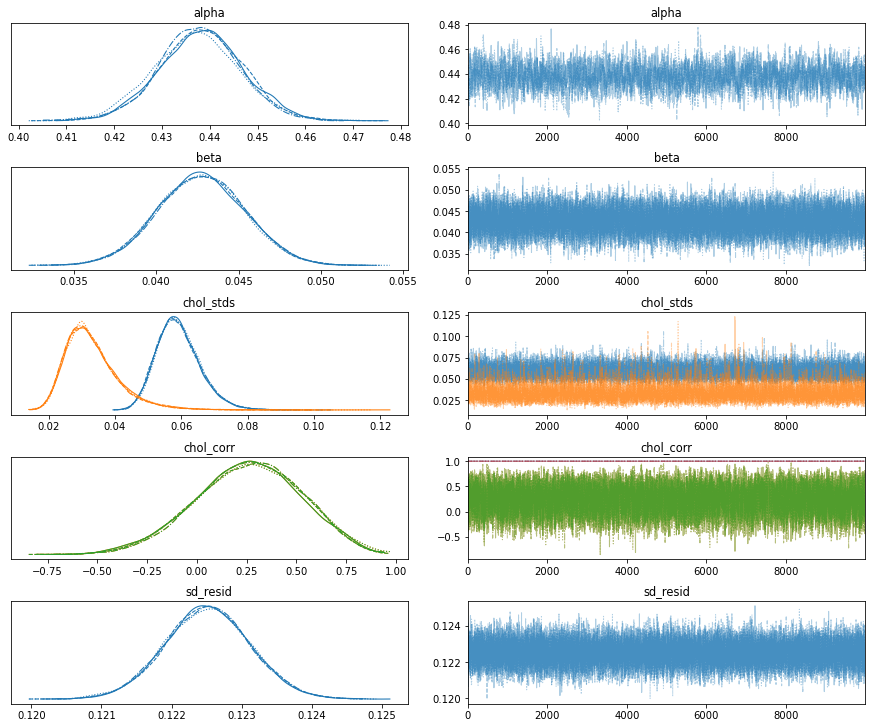

In [32]:
with flanker_model:
    az.plot_trace(trace, var_names=["alpha", "beta", "chol_stds", "chol_corr", "sd_resid"])

In [33]:
with flanker_model:
    display(az.summary(trace, var_names=["~gamma"]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.438,0.009,0.421,0.454,0.0,0.0,1474.0,2583.0,1.0
beta,0.043,0.003,0.038,0.048,0.0,0.0,11455.0,21667.0,1.0
"u_raw[0,0]",-0.023,0.011,-0.043,-0.002,0.0,0.0,2148.0,4478.0,1.0
"u_raw[0,1]",-0.002,0.028,-0.056,0.054,0.0,0.0,37689.0,22349.0,1.0
"u_raw[1,0]",-0.003,0.011,-0.023,0.017,0.0,0.0,2157.0,4483.0,1.0
...,...,...,...,...,...,...,...,...,...
u_1[42],-0.012,0.013,-0.037,0.000,0.0,0.0,14931.0,34565.0,1.0
u_1[43],-0.008,0.011,-0.034,0.001,0.0,0.0,17719.0,35016.0,1.0
u_1[44],0.001,0.006,-0.008,0.018,0.0,0.0,38334.0,32576.0,1.0
u_1[45],0.000,0.006,-0.014,0.015,0.0,0.0,41663.0,34374.0,1.0


In [34]:
df = pm.backends.tracetab.trace_to_dataframe(trace)

In [35]:
pips = df.filter(regex='gamma').apply(np.mean).to_numpy()

z = df.filter(regex='z_1__[0-9]+').apply(np.mean).to_numpy()

sd = df.filter(regex='chol_stds__1').apply(np.mean).to_numpy()

ranefs = z * sd

ValueError: x and y must have same first dimension, but have shapes (0,) and (47,)

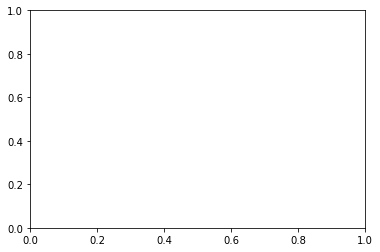

In [36]:
plt.plot(ranefs, pips, marker='.', ls='')
plt.show()

In [37]:
df.to_csv('flanker-ncp-posterior.csv')